<font size="6"> **Statistical Risk Model** </font>

$$ \vec{r}(N,T) = \vec{\beta}(N,K) · \vec{f}(K,T) + \vec{s}(N,T)$$

* from $\vec{f}$ compute `factor covariance matrix`: $\vec{F}$
* from $\vec{s}$ compute `idiosyncratic covariance matrix` $\vec{S}$ and extract diagonal

Use  $\vec{\beta}$, $\vec{F}$ and $\vec{S}$ to estimate portfolio risk: $\sigma_{r_{p}}$

In [1]:
%%capture
%run 01_riskfactor_data.ipynb

In [2]:
MODEL_VERSION = 'v01'
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import pickle

from mle_quant_utils import risk_utils


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [4]:
import yaml
import os

# Retrieve parameters from configuration file
with open("../conf.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile)

In [5]:
OUTPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['risk_factors']['folder'] + "/" + MODEL_VERSION + "/"
OUTFILE1 = cfg['output']['risk_factors']['model']
OUTFILE2 = cfg['output']['risk_factors']['model_metadata']

In [6]:
RND_SEED = 123

In [7]:
pd.concat([five_year_returns.head(2), five_year_returns.tail(2)],axis=0)

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2016-01-04 00:00:00+00:00,-0.028282,-0.033988,0.011494,0.000855,-0.027512,-0.017741,-0.044067,-0.025551,-0.020971,-0.015919,...,-0.024767,-0.024922,-0.006276,-0.032711,-0.031051,-0.011520,-0.011489,-0.007604,-0.021614,-0.013564
2016-01-05 00:00:00+00:00,0.004058,-0.009541,-0.006830,-0.025054,-0.004169,0.014629,-0.000247,0.005207,0.004023,-0.007347,...,0.002098,0.014863,0.008511,0.020390,-0.001957,-0.000286,-0.002495,0.020820,-0.010853,0.015647


# Compute PCA
Create an statistical Risk model by running a Principal Components Analysis on 5 years returns data. The time span selected to compute this statistical model is a very important choice, but 5 years is an industry standard

In [8]:
five_year_returns.head()

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.0,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.0,0.012457,-0.000181,-0.010458,0.0
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.0,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.0,0.001440,0.007784,-0.017945,0.0
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.0,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.0,-0.006470,0.035676,0.007467,0.0
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.0,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.0,0.002631,0.014741,-0.011903,0.0
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.0,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.0,-0.005084,-0.004665,-0.009178,0.0


In [9]:
X_train = five_year_returns[:valid_end]
X_test = five_year_returns[test_start:]

In [10]:
n_components =  [3, 5, 10, 20, 50]
k_folds = 3
exp_var = risk_utils.gridsearch_pca_expvar(X_train, n_components=n_components, k_folds=k_folds, random_state = RND_SEED)

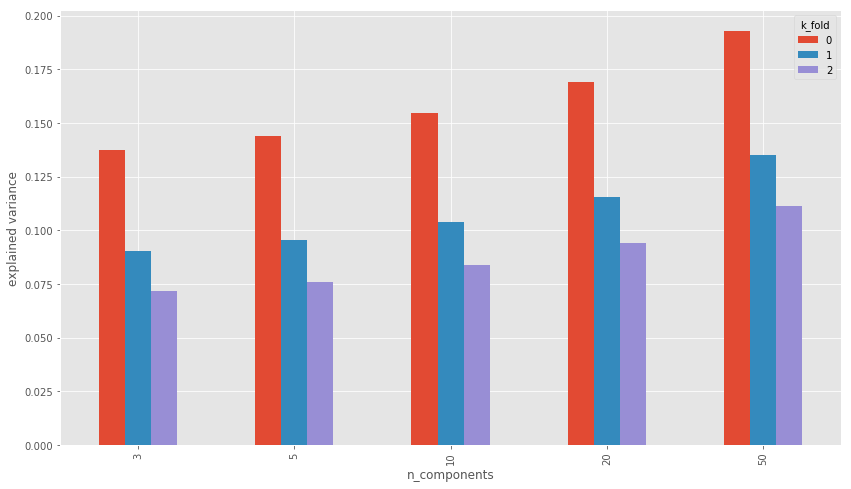

In [11]:
exp_var.plot.bar(label='folds')
plt.xlabel('n_components')
plt.ylabel('explained variance')
plt.legend(title='k_fold')
plt.show()

In [12]:
num_factor_exposures = 20

pca = risk_utils.fit_pca(X_train, num_factor_exposures, 'full', RND_SEED)

pca.components_.shape

(20, 490)

Let's also look at the PCA's percent of variance explained by each factor

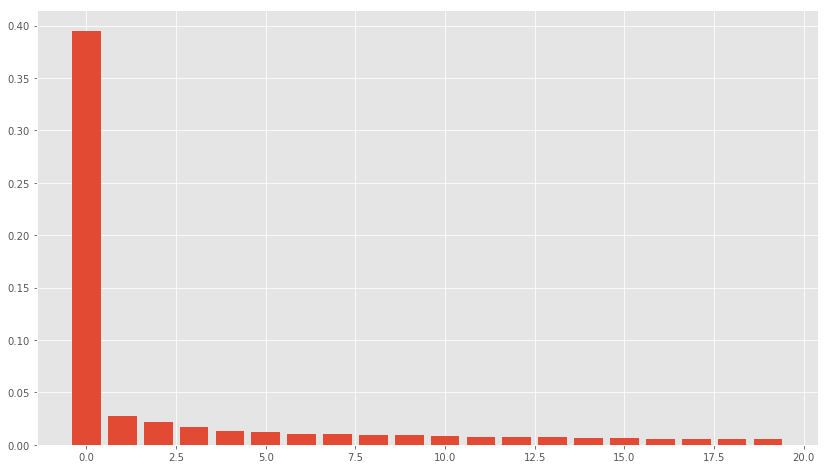

In [13]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)
plt.show()

The first factor dominates, this factor is defined by a set of loadings (weights applied to each input return), although, the precise definition of each factor in a latent model is unknown

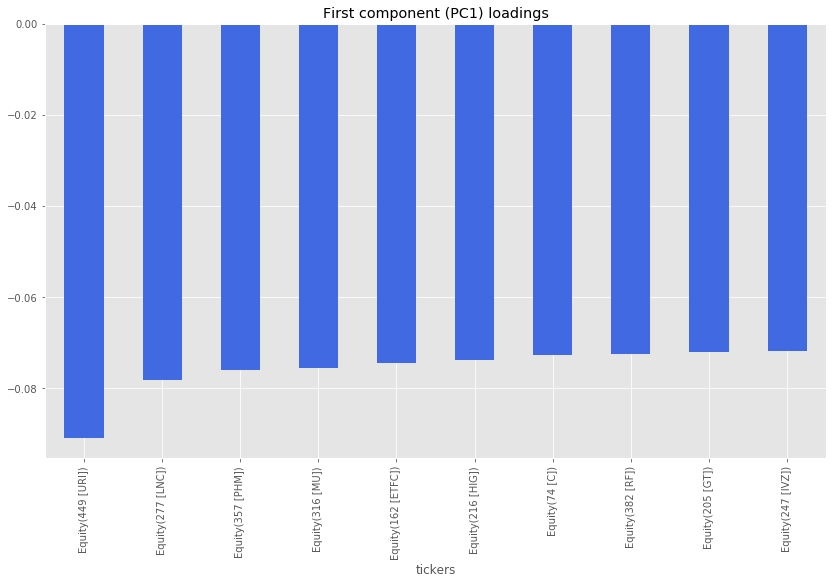

In [14]:
loadings = pd.Series(index= universe_tickers, data=pca.components_[0], name='PC1')
loadings.sort_values()[:10].plot.bar(color='royalblue', title='First component (PC1) loadings')
plt.xlabel('tickers')
plt.show()

# Factor Betas

$$ \vec{\beta}(N,K) $$
Implement `factor_betas` to get the factor betas from the PCA model.

In [15]:
risk_model = {}
risk_model_test = {}

risk_model['factor_betas'] = risk_utils.factor_betas(pca, X_train.columns.values, np.arange(num_factor_exposures))
risk_model_test['factor_betas'] = risk_model['factor_betas'].copy()

risk_model['factor_betas'][:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.042628,0.014983,0.012869,0.003801,-0.022948,0.010030,-0.004048,-0.006718,-0.034471,0.024555,-0.017108,0.018875,0.025266,0.014909,-0.026406,0.033897,-0.029173,-0.030546,-0.026341,-0.012199
Equity(1 [AAL]),-0.060402,0.258601,-0.037516,0.144527,0.296615,-0.080756,0.113555,-0.024766,-0.161712,-0.035469,0.043421,0.100238,-0.014771,-0.026967,0.015362,0.025396,-0.013467,-0.056342,0.067339,0.092211


# Factor Returns
$$ \vec{f}(T,K) $$
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [16]:
risk_model['factor_returns'] = risk_utils.factor_returns(
    pca,
    X_train,
    X_train.index,
    np.arange(num_factor_exposures))
risk_model['factor_returns'].index.name = 'date'

risk_model['factor_returns'][:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2011-01-07 00:00:00+00:00,0.002368,-0.017349,-0.014571,-0.006355,0.078109,-0.053794,0.024499,-0.056598,0.005596,-0.033146,-0.008397,-0.080584,0.047754,-0.019034,-0.031117,0.025826,-0.023411,-0.021086,-0.015933,-0.013473
2011-01-10 00:00:00+00:00,-0.000887,-0.023872,-0.072516,-0.001991,-0.026355,-0.062751,0.008012,0.060594,-0.016167,-0.033728,0.064455,0.016234,-0.007310,-0.003652,-0.028043,-0.006903,0.027921,0.005312,0.010000,0.018064


In [17]:
risk_model_test['factor_returns'] = risk_utils.factor_returns(
    pca,
    X_test,
    X_test.index,
    np.arange(num_factor_exposures))
risk_model_test['factor_returns'].index.name = 'date'
risk_model_test['factor_returns'][:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00+00:00,-0.231498,0.087009,-0.035185,-0.056721,0.006649,-0.014624,0.015049,-0.015601,-0.034371,0.031523,0.000828,-0.002096,0.017049,0.021042,0.019484,-0.058597,0.001738,-0.028662,0.026607,-0.074468
2015-05-04 00:00:00+00:00,-0.054719,0.007882,0.043880,0.020466,-0.049734,0.038801,-0.013299,0.006079,0.007780,-0.013627,0.000676,-0.017142,-0.028415,-0.011957,-0.016032,0.018925,-0.009592,0.018181,0.010830,-0.002648


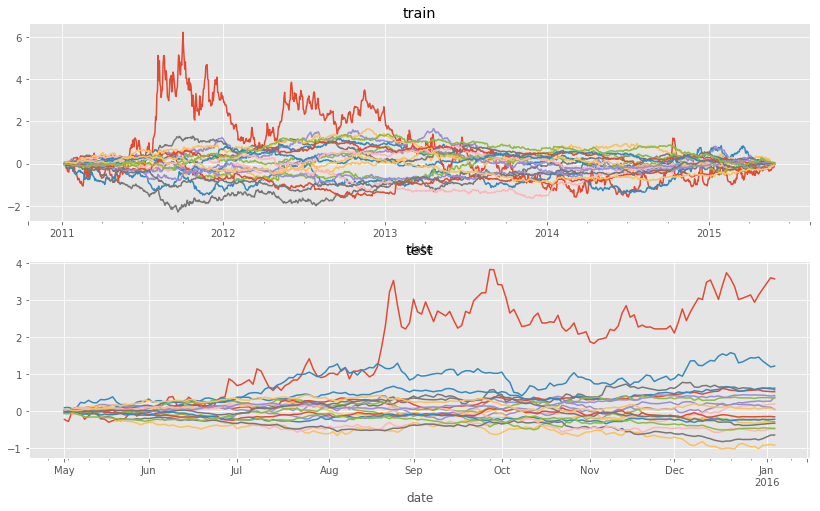

In [18]:
fig, axs = plt.subplots(2,1)
ax1, ax2 = axs
risk_model['factor_returns'].cumsum().plot(ax=ax1, title='train', legend=None)
risk_model_test['factor_returns'].cumsum().plot(ax=ax2, title='test', legend=None)
plt.show()

Recall that:



In this exersice, factor betas are assumed to be constant for the entire testing dataset, in a more refined scheme, factor betas may be updated daily. In hit scheme, is important to consider a time lag consisting:

Run simulation on day t (assumming a delay of 2 trading days):
* Compute daily factor betas:
$\beta_{i,j,t}$ -> run PCA (or any other method) from t-tau to t-1
* Compute factor returns
$$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$$
where $i=1...N$ (N assets), and $j=1...k$ (k factors).   
where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. 

In [19]:
factor_returns_test, factor_returns_expvar_test = risk_utils.compute_static_factor_returns(X_test, risk_model_test['factor_betas'])
factor_returns_test[0:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00+00:00,-0.247383,0.0922262,-0.0354954,-0.0619624,0.00731618,-0.0131741,0.0129828,-0.0158566,-0.0352023,0.0316504,0.000336804,-0.00118795,0.0155665,0.0224999,0.0202206,-0.0593176,0.000436518,-0.0280153,0.0272384,-0.0753836
2015-05-04 00:00:00+00:00,-0.0706037,0.0130992,0.0435694,0.0152248,-0.049067,0.0402508,-0.0153655,0.00582366,0.00694788,-0.0134997,0.000184609,-0.0162333,-0.0298968,-0.0104986,-0.0152951,0.0182046,-0.0108934,0.0188279,0.0114606,-0.00356342


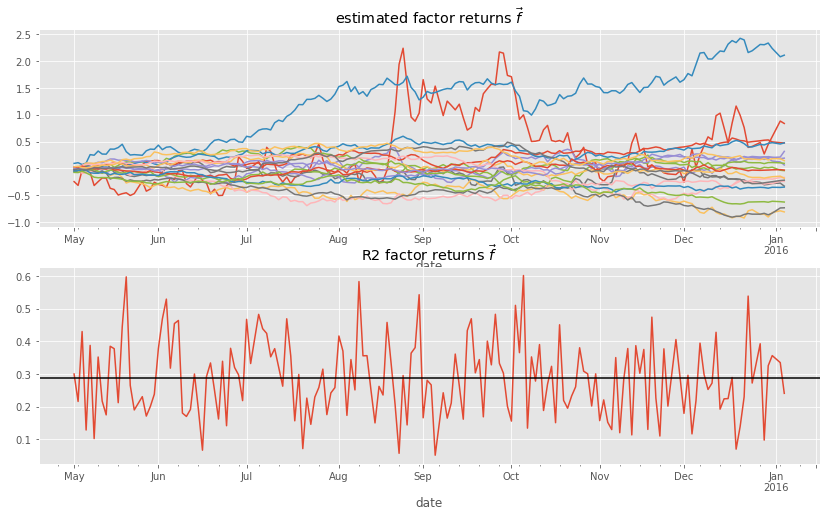

In [20]:
fig, axs = plt.subplots(2,1)
ax1, ax2 = axs

factor_returns_test.cumsum().plot(ax=ax1, title=r'estimated factor returns $\vec{f}$', legend=None)
factor_returns_expvar_test.plot(ax=ax2, title=r'R2 factor returns $\vec{f}$')
ax2.axhline(y=factor_returns_expvar_test.mean(), color='black')
plt.show()

# Covariance Matrix Estimation

## Factor Covariance Matrix
$$ \vec{F}(K,K) $$
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [21]:
ann_factor = 252
risk_model['factor_cov_matrix'] = risk_utils.factor_cov_matrix(risk_model['factor_returns'], ann_factor)
risk_model_test['factor_cov_matrix'] = risk_utils.factor_cov_matrix(risk_model_test['factor_returns'], ann_factor)

print(risk_model['factor_cov_matrix'].shape)
risk_model['factor_cov_matrix'][:2]

(20, 20)


array([[13.97417511,  0.        ,  0.        , -0.        , -0.        ,
         0.        , -0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ],
       [ 0.        ,  0.97156884,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [22]:
risk_model['factor_var_vector'] = risk_utils.factor_var_vector(risk_model['factor_returns'], risk_model['factor_cov_matrix'])
risk_model_test['factor_var_vector'] = risk_utils.factor_var_vector( risk_model_test['factor_returns'], risk_model_test['factor_cov_matrix'])

## Idiosyncratic Variance Matrix
$$ \vec{S}(N,N) $$
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [23]:
idiosyncratic_var_matrix = risk_utils.idiosyncratic_var_matrix(X_train, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)
idiosyncratic_var_matrix_test = risk_utils.idiosyncratic_var_matrix(X_test, risk_model_test['factor_returns'], risk_model_test['factor_betas'], ann_factor)

idiosyncratic_var_matrix[:2]

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.023605,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Equity(1 [AAL]),0.000000,0.05303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
idiosyncratic_var_matrix.shape

(490, 490)

In [25]:
risk_model['idiosyncratic_var_vector'] = risk_utils.idiosyncratic_var_vector(X_train, idiosyncratic_var_matrix)
risk_model_test['idiosyncratic_var_vector'] = risk_utils.idiosyncratic_var_vector(X_test, idiosyncratic_var_matrix_test)


risk_model['idiosyncratic_var_vector'][:2]

,0
Equity(0 [A]),0.023605
Equity(1 [AAL]),0.053030


# Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sigma_{r_{p}} = \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

Let's see what the portfolio risk would be if we had even weights across all stocks.

In [26]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

risk_utils.predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    idiosyncratic_var_matrix,
    all_weights)

0.159473730783234

# Write Risk Model

In [27]:
metadata = {
    'train_start_dt': X_train.index[0].strftime('%Y-%m-%d'),
    'factor_start_dt': test_dates[0].strftime('%Y-%m-%d'),
    'factor_end_dt': test_dates[-1].strftime('%Y-%m-%d'),
    'model': 'pca',
    'kind': 'static'}

In [28]:
risk_model_test['idiosyncratic_var_vector'].index = [x.symbol for x in risk_model_test['idiosyncratic_var_vector'].index]
risk_model_test['idiosyncratic_var_vector'].index.name = 'asset'

In [29]:
risk_model_test['factor_betas'].index = [x.symbol for x in risk_model_test['factor_betas'].index]
risk_model_test['factor_betas'].index.name = 'asset'

In [30]:
model_dt = X_train.index[-1].strftime('%Y%m%d')

with open(OUTPATH + OUTFILE1, 'wb') as file:
    pickle.dump({model_dt: pca}, file)
    
with open(OUTPATH + OUTFILE2, 'wb') as file:
    pickle.dump(metadata, file)

In [31]:
risk_model_test.keys()

dict_keys(['factor_returns', 'factor_var_vector', 'factor_cov_matrix', 'factor_betas', 'idiosyncratic_var_vector'])

In [32]:
for key, data in risk_model_test.items():
    path = OUTPATH + key + ".csv"
    if isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
        print("Writing: {}".format(key))
        data.to_csv(path)

Writing: factor_returns
Writing: factor_var_vector
Writing: factor_betas
Writing: idiosyncratic_var_vector
